In [ ]:
import copy
import os
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from tqdm import tqdm

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#################################################################   
####################Physics-Informed Neural Network #############
NUM_EPOCHS = 100000
LEARNING_RATE = 1e-4
NUM_COLLOCATION = 10000
PATIENCE = 1000
THRESHOLD = 1e-3
EARLY_STOPPING_EPOCH = 100000
NUM_SAMPLES = 1000

T_START = 0.0
T_END = 6.0
dt = 0.1

X_MIN = 5.0
X_MAX = 45.0
S_MIN = 0.1
S_MAX = 5.0
V_MIN = 1.0
V_MAX = 3.0
F_MIN = 0.0
F_MAX = 0.1

# --- Model Parameters ---
MU_MAX = 0.86980    # 1/h
K_S = 0.000123762    # g/l
Y_XS = 0.435749      # g/g
S_F = 286           # g/l

# Initial Conditions
X_0, S_0, V_0 = 5, 0.013, 1.7  # Biomass, Substrate, Volume

# ODE solver parameters
ODE_SOLVER = 'LSODA'

In [15]:
def numpy_to_tensor(array):
    return torch.tensor(array, requires_grad=True, dtype=torch.float32).to(DEVICE).reshape(-1, 1)

def grad(outputs, inputs):
    return torch.autograd.grad(outputs.sum(), inputs, create_graph=True)[0]

class PINN(nn.Module):
    def __init__(self, input_dim: int, output_dim: int):
        super().__init__()
        self.input = nn.Linear(input_dim, 64)
        self.hidden = nn.Linear(64, 256)
        self.hidden2 = nn.Linear(256, 256)
        self.hidden3 = nn.Linear(256, 64)
        self.output = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.tanh(self.input(x))
        x = torch.tanh(self.hidden(x))
        x = torch.tanh(self.hidden2(x))
        x = torch.tanh(self.hidden3(x))
        x = self.output(x)
        return x

In [16]:
def generate_dataset(num_samples: int = NUM_SAMPLES):
    """Generate dataset of random multiple initial conditions and control actions"""
    df = pd.DataFrame(columns=['t', 'X', 'S', 'F'])
    df['X'] = np.random.uniform(X_MIN, X_MAX, num_samples)
    df['S'] = np.random.uniform(S_MIN, S_MAX, num_samples)
    df['F'] = np.random.uniform(F_MIN, F_MAX, num_samples)
    df['t'] = 0.0 # initial time (always 0)

    t_train = numpy_to_tensor(df['t'].values)
    X_train = numpy_to_tensor(df['X'].values)
    S_train = numpy_to_tensor(df['S'].values)
    F_train = numpy_to_tensor(df['F'].values)
    
    in_train = torch.cat([t_train, X_train, S_train, F_train], dim=1)
    out_train = torch.cat([X_train, S_train], dim=1)
    
    return in_train, out_train

def loss_fn(net: nn.Module) -> torch.Tensor:
    t_col = numpy_to_tensor(np.random.uniform(T_START, dt, NUM_COLLOCATION))
    X0_col = numpy_to_tensor(np.random.uniform(X_MIN, X_MAX, NUM_COLLOCATION))
    S0_col = numpy_to_tensor(np.random.uniform(S_MIN, S_MAX, NUM_COLLOCATION))
    V0_col = numpy_to_tensor(np.random.uniform(V_MIN, V_MAX, NUM_COLLOCATION))
    F_col  = numpy_to_tensor(np.random.uniform(F_MIN, F_MAX, NUM_COLLOCATION))
    
    u_col = torch.cat([t_col, X0_col, S0_col, F_col], dim=1)
    preds = net.forward(u_col)

    X_pred = preds[:, 0].view(-1, 1)
    S_pred = preds[:, 1].view(-1, 1)
    V_pred = V0_col + F_col * dt

    dXdt_pred = grad(X_pred, t_col)
    
    mu = MU_MAX * S_pred / (K_S + S_pred)

    # residuals
    rhs_X = mu * X_pred - (F_col / V_pred) * X_pred
        
    error_dXdt = dXdt_pred - rhs_X

    loss_ode = torch.mean(error_dXdt**2) 
                
    return loss_ode


In [17]:
in_train, out_train = generate_dataset()

print(f'Input shape: {in_train.shape}')
print(f'Output shape: {out_train.shape}')

Input shape: torch.Size([1000, 4])
Output shape: torch.Size([1000, 2])


In [ ]:
model_name = "pinc_model_v5.pth"
model_exists = os.path.exists(f'./models/{model_name}')

if model_exists:
    # Load the model
    net = PINN(input_dim=in_train.shape[1], output_dim=out_train.shape[1]).to(DEVICE)
    net.load_state_dict(torch.load(f'./models/{model_name}', weights_only=True))
    net.eval()
else:
    # Main
    net = PINN(input_dim=in_train.shape[1], output_dim=out_train.shape[1]).to(DEVICE)
    optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2500, gamma=0.8)

    # Loss weights
    w_data, w_ode, w_ic = 1.0, 10.0, 1.0

    # Initialize early stopping variables
    best_loss = float("inf")
    best_model_weights = None
    patience = PATIENCE
    threshold = THRESHOLD
    pretrain_epochs = 1000

    for epoch in tqdm(range(NUM_EPOCHS)):
        optimizer.zero_grad()
        preds = net.forward(in_train)
        X_pred = preds[:, 0].view(-1, 1)
        S_pred = preds[:, 1].view(-1, 1)
        w_X, w_S = 1.0, 1.0
        loss_data = (w_X * torch.mean((X_pred - out_train[:, 0].view(-1, 1))**2) + 
                     w_S * torch.mean((S_pred - out_train[:, 1].view(-1, 1))**2)) / 2
        if epoch < pretrain_epochs:
            loss = loss_data * w_data
        else:
            loss_ode = loss_fn(net)
            loss = w_data * loss_data + w_ode * loss_ode
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        if epoch % 500 == 0:
            if epoch < pretrain_epochs:
                print(f"Epoch {epoch}: Loss = {loss_data.item():.4e}")
            else:
                print(f"Epoch {epoch}: Loss = {loss.item():.4e}, Data Loss = {loss_data.item():.4e}, ODE Loss = {loss_ode.item():.4e}")
        
        # Early stopping
        if epoch >= EARLY_STOPPING_EPOCH:
            if loss.item() < best_loss - threshold:
                best_loss = loss.item()
                best_model_weights = copy.deepcopy(net.state_dict())
                patience = PATIENCE
            else:
                patience -= 1
                if patience <= 0:
                    print(f"Early stopping at epoch {epoch}. Best loss: {best_loss:.4e} at epoch {epoch - PATIENCE}.")
                    break

    # Load best model weights
    if best_model_weights is not None:
        net.load_state_dict(best_model_weights)
        net.eval()
        print("Loaded best model weights.")
    else:
        print("No model weights to load.")
        net.eval()

    # Save the model
    torch.save(net.state_dict(), f'./models/{model_name}')


  0%|          | 30/100000 [00:00<05:38, 295.57it/s]

Epoch 0: Loss = 3.8156e+02


  1%|          | 569/100000 [00:01<04:38, 356.69it/s]

Epoch 500: Loss = 2.1997e+02


  1%|          | 1008/100000 [00:02<05:37, 293.40it/s]

Epoch 1000: Loss = 9.3261e+02, Data Loss = 1.7224e+02, ODE Loss = 7.6037e+01


  2%|▏         | 1529/100000 [00:06<10:23, 158.04it/s]

Epoch 1500: Loss = 2.2624e+02, Data Loss = 2.2109e+02, ODE Loss = 5.1575e-01


  2%|▏         | 2020/100000 [00:09<10:07, 161.36it/s]

Epoch 2000: Loss = 1.9186e+02, Data Loss = 1.9002e+02, ODE Loss = 1.8480e-01


  3%|▎         | 2528/100000 [00:12<10:06, 160.66it/s]

Epoch 2500: Loss = 1.6629e+02, Data Loss = 1.6551e+02, ODE Loss = 7.8350e-02


  3%|▎         | 3023/100000 [00:15<10:15, 157.59it/s]

Epoch 3000: Loss = 1.4728e+02, Data Loss = 1.4625e+02, ODE Loss = 1.0358e-01


  4%|▎         | 3536/100000 [00:18<09:25, 170.59it/s]

Epoch 3500: Loss = 1.2970e+02, Data Loss = 1.2832e+02, ODE Loss = 1.3838e-01


  4%|▍         | 4030/100000 [00:21<09:42, 164.74it/s]

Epoch 4000: Loss = 1.1460e+02, Data Loss = 1.1360e+02, ODE Loss = 9.9921e-02


  5%|▍         | 4536/100000 [00:23<06:39, 239.09it/s]

Epoch 4500: Loss = 9.6944e+01, Data Loss = 9.5952e+01, ODE Loss = 9.9211e-02


  5%|▌         | 5042/100000 [00:26<06:51, 230.63it/s]

Epoch 5000: Loss = 8.1745e+01, Data Loss = 8.0261e+01, ODE Loss = 1.4845e-01


  6%|▌         | 5527/100000 [00:28<08:52, 177.27it/s]

Epoch 5500: Loss = 7.0675e+01, Data Loss = 6.9542e+01, ODE Loss = 1.1332e-01


  6%|▌         | 6034/100000 [00:31<09:26, 165.90it/s]

Epoch 6000: Loss = 6.0483e+01, Data Loss = 5.9582e+01, ODE Loss = 9.0071e-02


  7%|▋         | 6526/100000 [00:34<10:04, 154.68it/s]

Epoch 6500: Loss = 5.1141e+01, Data Loss = 5.0110e+01, ODE Loss = 1.0318e-01


  7%|▋         | 7026/100000 [00:37<07:37, 203.40it/s]

Epoch 7000: Loss = 4.2998e+01, Data Loss = 4.1053e+01, ODE Loss = 1.9452e-01


  8%|▊         | 7525/100000 [00:40<09:36, 160.54it/s]

Epoch 7500: Loss = 3.5248e+01, Data Loss = 3.4278e+01, ODE Loss = 9.6992e-02


  8%|▊         | 8032/100000 [00:43<09:27, 162.04it/s]

Epoch 8000: Loss = 2.9845e+01, Data Loss = 2.8626e+01, ODE Loss = 1.2183e-01


  9%|▊         | 8527/100000 [00:46<08:42, 175.22it/s]

Epoch 8500: Loss = 2.5498e+01, Data Loss = 2.4460e+01, ODE Loss = 1.0384e-01


  9%|▉         | 9033/100000 [00:49<07:38, 198.61it/s]

Epoch 9000: Loss = 2.1452e+01, Data Loss = 2.0163e+01, ODE Loss = 1.2896e-01


 10%|▉         | 9529/100000 [00:52<09:18, 161.99it/s]

Epoch 9500: Loss = 1.8276e+01, Data Loss = 1.7152e+01, ODE Loss = 1.1238e-01


 10%|█         | 10036/100000 [00:55<07:22, 203.21it/s]

Epoch 10000: Loss = 1.6850e+01, Data Loss = 1.3398e+01, ODE Loss = 3.4519e-01


 11%|█         | 10539/100000 [00:57<06:41, 223.03it/s]

Epoch 10500: Loss = 1.2704e+01, Data Loss = 1.1701e+01, ODE Loss = 1.0022e-01


 11%|█         | 11027/100000 [01:00<09:12, 161.17it/s]

Epoch 11000: Loss = 1.0970e+01, Data Loss = 9.9966e+00, ODE Loss = 9.7341e-02


 12%|█▏        | 11519/100000 [01:03<08:54, 165.46it/s]

Epoch 11500: Loss = 9.1623e+00, Data Loss = 8.3080e+00, ODE Loss = 8.5428e-02


 12%|█▏        | 12031/100000 [01:06<09:35, 152.89it/s]

Epoch 12000: Loss = 7.7639e+00, Data Loss = 6.9133e+00, ODE Loss = 8.5058e-02


 13%|█▎        | 12518/100000 [01:09<09:07, 159.64it/s]

Epoch 12500: Loss = 6.6966e+00, Data Loss = 5.6101e+00, ODE Loss = 1.0866e-01


 13%|█▎        | 13034/100000 [01:12<08:45, 165.45it/s]

Epoch 13000: Loss = 5.5297e+02, Data Loss = 1.3062e+01, ODE Loss = 5.3991e+01


 14%|█▎        | 13531/100000 [01:15<09:01, 159.65it/s]

Epoch 13500: Loss = 3.0925e+01, Data Loss = 1.1082e+01, ODE Loss = 1.9843e+00


 14%|█▍        | 13956/100000 [01:18<08:45, 163.81it/s]

In [ ]:
# Load the model
net = PINN(input_dim=in_train.shape[1], output_dim=out_train.shape[1]).to(DEVICE)
net.load_state_dict(torch.load(f'./models/{model_name}', weights_only=True))
net.eval()

def flow_rate(t: float) -> float:
    """Flow rate as a function of time"""
    if t < 0.5:
        return 0.1
    elif t < 1.0:
        return 0.1
    elif t < 2.0:
        return 0.1
    elif t < 3.0:
        return 0.1
    else:
        return 0.03

# System dynamics
def system_dynamics(t: float, y: float, F: Union[callable, float]) -> np.array:
    X, S, V = y
    Fs = F(t) if callable(F) else F
    dX_dt = (MU_MAX * S / (K_S + S)) * X - (Fs / V) * X
    dS_dt = -(1 / Y_XS) * (MU_MAX * S / (K_S + S)) * X + (Fs / V) * (S_F - S)
    dV_dt = Fs
    return np.array([dX_dt, dS_dt, dV_dt])

def solve_ode(ode: callable, t_span: list, y0: list, method: str, t_eval: list, args: tuple) -> solve_ivp:
    sol = solve_ivp(ode, t_span=t_span, y0=y0, method=method, args=args, t_eval=t_eval, rtol=1e-6, atol=1e-12)
    # sol.y = np.maximum(sol.y, 0)
    return sol

sol = solve_ode(system_dynamics, t_span=[T_START, T_END], y0=[X_0, S_0, V_0], method=ODE_SOLVER, \
                t_eval=np.arange(T_START, T_END, dt), args=(flow_rate,))
df = pd.DataFrame(sol.y.T, columns=['X', 'S', 'V'])
df['Time'] = sol.t

T_s = 0.1
t_test = numpy_to_tensor(np.array([df['Time'].values]))
X_test = numpy_to_tensor(np.array([df['X'].values]))
S_test = numpy_to_tensor(np.array([df['S'].values]))
V_test = numpy_to_tensor(np.array([df['V'].values]))
F_test = numpy_to_tensor(np.array([flow_rate(t) for t in df['Time'].values]))
u_test = torch.cat([t_test, X_test, S_test, F_test], dim=1)
x_test = torch.cat([X_test, S_test], dim=1)

X_0 = X_test[0]
S_0 = S_test[0]
F_0 = F_test[0]

X_preds = []
S_preds = []

net.eval()
for i in range(len(u_test)):

    if i == 0:
        X_preds.append(X_0.item())
        S_preds.append(S_0.item())
        continue

    x_k = net.forward(torch.tensor([T_s, X_0, S_0, F_0], dtype=torch.float32).to(DEVICE))
    X_0 = X_test[i]
    S_0 = S_test[i]
    F_0 = F_test[i]
    X_preds.append(x_k[0].item())
    S_preds.append(x_k[1].item())

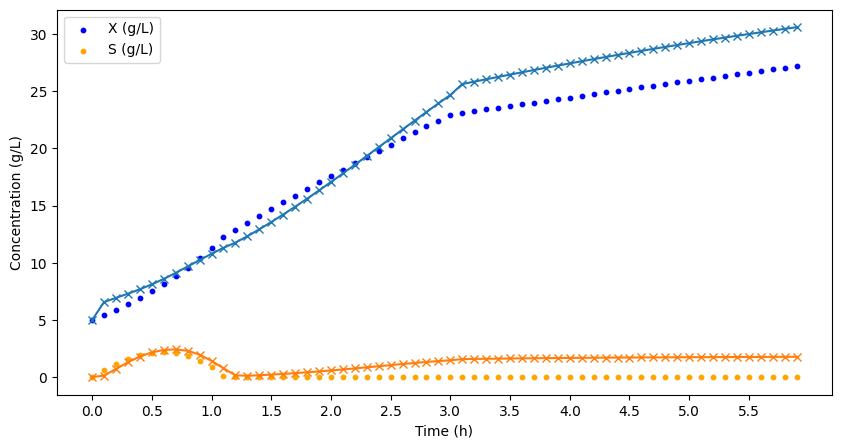

In [ ]:
plt.figure(figsize=(10, 5))
plt.scatter(df['Time'], df['X'], label='X (g/L)', color='blue', s=10)
plt.scatter(df['Time'], df['S'], label='S (g/L)', color='orange', s=10)

plt.plot(t_test.detach().cpu().numpy(), X_preds, marker='x', label="_X_pred")
plt.plot(t_test.detach().cpu().numpy(), S_preds, marker='x', label="_S_pred")
plt.ylabel("Concentration (g/L)")
plt.legend(loc="best") 

plt.xticks(np.arange(0, 6, 0.5))
plt.xlabel("Time (h)")
plt.show()